# Use a Recurrent Neural Net to find Baby Names

I need a good name for a baby!  It should be unique, but not too weird.  Use an RNN to find some plausible baby names that have never been used.

First get some baby names from the social security administration:

In [1]:
!wget https://www.ssa.gov/oact/babynames/names.zip

--2017-09-04 20:06:03--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 137.200.39.19, 2001:1930:d07::aaaa
Connecting to www.ssa.gov (www.ssa.gov)|137.200.39.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8207194 (7.8M) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]   7.83M  3.15MB/s    in 2.5s    

2017-09-04 20:06:05 (3.15 MB/s) - ‘names.zip’ saved [8207194/8207194]



Next, extract the name info:

In [2]:
import zipfile
zip_ref = zipfile.ZipFile('./names.zip', 'r')
zip_ref.extractall('./names/')
zip_ref.close()

Load some libraries, print out the versions:

In [3]:
import glob, re
import matplotlib.pyplot as plt
import pandas as pd
import keras 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
%matplotlib inline
%load_ext version_information
%version_information pandas, numpy, keras, matplotlib

Using TensorFlow backend.


Software versions
Python 3.5.2 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.4.0 93 generic x86_64 with debian stretch sid
pandas 0.20.1
numpy 1.11.3
keras 2.0.5
matplotlib 2.0.2
Mon Sep 04 20:06:09 2017 EDT

Read in the name files:

In [4]:
master = pd.DataFrame()
for f in glob.glob('./names/yob*.txt'):
    yr = int(re.findall('\\d+',f)[0])
    dat=pd.read_csv(f,names=['Name','Gender','Count'])
    dat['Year']=yr
    dat['Name']=dat['Name'].str.lower()
    dat['Fraction'] = dat.groupby('Gender',group_keys=False).apply(lambda f: f.Count/f.Count.sum())
    master=master.append(dat)

gender=master.groupby('Gender')
boys = gender.get_group('M').sort_values('Year')
girls = gender.get_group('F').sort_values('Year')

Next, inspect the data 

In [5]:
print(master.sample(20))


            Name Gender  Count  Year  Fraction
27142      mayur      M      7  2002  0.000004
8886    garielle      F     12  2004  0.000007
8091   cristobal      M     23  1953  0.000012
9204      carvin      M      6  1928  0.000005
15595    tarrant      M      5  1973  0.000003
20883       kory      M     81  2015  0.000042
9191       jerri      M      7  1948  0.000004
1669    migdalia      F     32  1950  0.000019
11527    refujio      M      6  1962  0.000003
464       haylee      F    543  1994  0.000304
17699    javarus      M      5  1978  0.000003
10784     tylene      F      7  1989  0.000004
1522      dagmar      F      6  1901  0.000025
17707   macallan      F      5  2016  0.000003
6027      jersie      F     21  2016  0.000012
3165      davita      F     16  1965  0.000009
7184     gurnoor      F     18  2007  0.000009
28338     jossue      M      8  2014  0.000004
7936       jerra      F      5  1969  0.000003
6369        ruta      F      5  1953  0.000003


# Inspect some names over time

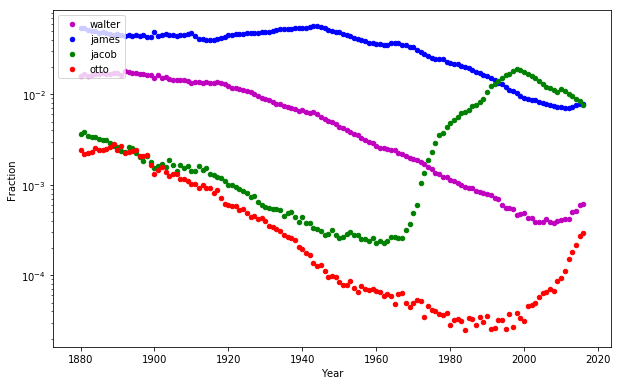

In [6]:
names=['walter','james','jacob','otto']
colors=['m','b','g','r']
plt.figure(figsize=(10,6.2))
ax=plt.gca()
for name,col in zip(names,colors):
    ax=boys[boys['Name']==name].plot('Year','Fraction',
                                     kind='scatter',logy=True,
                                     c=col,label=name,ax=ax)
plt.legend(loc='upper left')

Find names that are <0.05% but have been increasing recently

In [7]:
namesnow = girls.loc[(girls.Fraction<5e-4)& (girls.Fraction>1e-4)&((girls.Year==2016) |(girls.Year==2013)) ,:]

name_piv = pd.pivot_table(namesnow,values='Fraction',index=['Name'],columns=['Year'])
name_piv['Delta']=(name_piv[2016]-name_piv[2013])/name_piv[2016]
promising = name_piv.Delta.nlargest(30)
print(promising)


Name
remington    0.652234
ophelia      0.648767
aviana       0.648063
margot       0.637247
saylor       0.611804
avianna      0.605694
maisie       0.591520
magnolia     0.577816
lennon       0.577528
carter       0.570391
ariyah       0.565308
zelda        0.564787
julieta      0.547190
adley        0.541589
poppy        0.523006
jessa        0.517731
addilynn     0.516430
milani       0.495600
ariadne      0.488748
jolene       0.488532
zaylee       0.487759
oakley       0.483646
elora        0.481632
henley       0.467801
itzayana     0.458151
everleigh    0.449295
collins      0.447726
remy         0.444301
lilith       0.442420
braelynn     0.442174
Name: Delta, dtype: float64


For fun, how many girls names are palindromes?

In [8]:
def is_palindrome(s):
    return(str(s) == str(s)[::-1])

p=girls.Name.copy().map(is_palindrome).values
girls.loc[p,:].groupby(['Name']).agg('median').sort_values('Fraction',ascending=False)

,Count,Year,Fraction
Name,,,
anna,5429.0,1948.0,0.004743
hannah,295.0,1948.0,0.000667
ada,628.0,1948.0,0.000403
ava,156.0,1948.0,0.000155
ana,224.0,1948.5,0.000131
eve,127.0,1948.0,0.000111
nan,51.0,1940.5,0.000108
aja,194.0,1995.0,0.000106
elle,170.0,1999.0,0.000096


# Train the Recurrent Neural Net

Ok, get to work: build RNN model for girl's names using the Keras text generation [example](https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py) as a starting point:

In [9]:
# blatant steal from : https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py


text = ' '.join(girls['Name'].values)
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 12
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 10):
    print('-' * 50)
    print('Iteration', iteration)
    results=model.fit(X, y,
              batch_size=128,
              epochs=1,
              verbose=0)
    print('Loss: {:3.2f}'.format(results.history['loss'][0]))


corpus length: 8172527
total chars: 27
nb sequences: 2724172
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Loss: 1.53

--------------------------------------------------
Iteration 2
Loss: 1.45

--------------------------------------------------
Iteration 3
Loss: 1.49

--------------------------------------------------
Iteration 4
Loss: 1.56

--------------------------------------------------
Iteration 5
Loss: 1.55

--------------------------------------------------
Iteration 6
Loss: 1.49

--------------------------------------------------
Iteration 7
Loss: 1.51

--------------------------------------------------
Iteration 8
Loss: 1.55

--------------------------------------------------
Iteration 9
Loss: 1.54


With the trained model, generate some predictions, then use `set` to find names that are not in the training set:

In [10]:
generated=''
diversity=0.5
sentence='sweet peanut'  # seed text to kick off predictions
for i in range(40000):
    x = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char
    
names = set(generated.split(' '))-set(girls['Name'])

/home/jak/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: RuntimeWarning: divide by zero encountered in log


In [11]:
len(names)

696

And here are the new unique names:

In [13]:
' '.join([n for n in names if len(n)<12 ])

' kaidane denas ailan sumonn alexyann kaide alechitha erenda geralee genaline allessia kendaline jesseman tamary berden andreda analila takika tannna laris eleshie kenndale brittti anavia lareena bernardene challe arila rannell marimargen aryshia delme alexika alaka annesta alexss brynita adalese jakoli arelee ellandra vennet dortheen dusta mardis jolann marylonda amyleen deris ellalie laverni lavetha annari addacia janabel arleya adeletta alexstann naybella latila sumoda dorenn lavandra jasselyn abrylah brittann achaunda arlan aleahna amaera arlanna alexs alessamai kathlenn marylune marisone carsley estephann timmar ardille britttie kirlynn neali argina trody ardi alayley janinia gennesta delce katisa lurestina alessha ardenna alexan addyla latiley alexene kireni analika janicha alann juliuna amelyn makindra myrine laryla amardina nealia sumonda latieann genarie alayyah jadema lenella yaah arylani lavann jacquelinen larise abiga kendlee lavari conchice deneas arteris tymiah nee adola 